In [ ]:
# データの読み込み

In [42]:
!curl -O https://raw.githubusercontent.com/itamarcaspi/experimentdatar/master/data/vouchers.rda
!pip install -q rdata
import rdata

parsed = rdata.parser.parse_file('./vouchers.rda')
converted = rdata.conversion.convert(parsed)
vouchers = converted['vouchers']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0   902k      0 --:--:-- --:--:-- --:--:--  902k


/usr/local/lib/python3.6/dist-packages/rdata/conversion/_conversion.py:495: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  stacklevel=1)
/usr/local/lib/python3.6/dist-packages/rdata/conversion/_conversion.py:495: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  stacklevel=1)


In [58]:
regression_data = vouchers[(vouchers['TAB3SMPL'] == 1) & (vouchers['BOG95SMP'] == 1)].reset_index(drop=True)

In [59]:
regression_data

,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,INSCHL,PRSCH_C,PRSCHA_1,PRSCHA_2,VOUCH0,BOG95ASD,BOG97ASD,JAM93ASD,DBOGOTA,DJAMUNDI,D1995,D1997,RESPONSE,TEST_TAK,SEX_NAME,SVY,D1993,PHONE,DAREA1,DAREA2,DAREA3,DAREA4,DAREA5,DAREA6,DAREA7,DAREA8,DAREA9,DAREA10,DAREA11,DAREA12,DAREA13,...,DMONTH4,DMONTH5,DMONTH6,DMONTH7,DMONTH8,DMONTH9,DMONTH10,DMONTH11,DMONTH12,BOG95,BOG97,MOM_SCH,MOM_AGE,MOM_MW,DAD_SCH,DAD_AGE,DAD_MW,SEX2,STRATA1,STRATA2,STRATA3,STRATA4,STRATA5,STRATA6,STRATAMS,REPT6,TOTSCYRS,HASCHILD,MARRIED,WORKING,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
0,3.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,45.0,0.0,2.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,4.0,1.0,0.0,0.0,1.0,14.0,12.0,0.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,36.0,0.0,11.0,43.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,5.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,38.0,0.0,5.0,41.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6.0,1.0,0.0,0.0,0.0,12.0,10.0,0.0,7.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,30.0,0.0,8.0,36.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,10.0,1.0,0.0,0.0,1.0,14.0,11.0,0.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,37.0,0.0,5.0,41.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,3997.0,1.0,0.0,0.0,0.0,16.0,NaN,1.0,6.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,38.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1143,4006.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,52.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1144,4022.0,1.0,0.0,0.0,0.0,16.0,13.0,0.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,48.0,0.0,2.0,58.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1145,4023.0,1.0,0.0,0.0,0.0,16.0,13.0,0.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,52.0,0.0,7.0,52.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


# 回帰分析

In [61]:
# 回帰式の定義
formula_x_base = ['VOUCH0']
formula_x_covariate = [
    'SVY', 'HSVISIT', 'AGE', 'STRATA1', 'STRATA2', 'STRATA3', 'STRATA4', 'STRATA5', 'STRATA6', 'STRATAMS',
    'D1993', 'D1995', 'D1997', 'DMONTH1', 'DMONTH2', 'DMONTH3', 'DMONTH4', 'DMONTH5', 'DMONTH6',
    'DMONTH7', 'DMONTH8', 'DMONTH9', 'DMONTH10', 'DMONTH11', 'DMONTH12', 'SEX2',
]
formula_ys = [
    "TOTSCYRS","INSCHL","PRSCH_C","USNGSCH","PRSCHA_1","FINISH6","FINISH7","FINISH8","REPT6",
    "REPT","NREPT","MARRIED","HASCHILD","HOURSUM","WORKING3",
]

In [95]:
import pandas as pd
from statsmodels.formula.api import ols

# 回帰結果を受け取る関数の定義
def get_regression_result(formula, data):
  model = ols(formula, data=data).fit()
  result = pd.read_html(model.summary().tables[1].as_html(), header=0)[0]
  result.columns = ['term', 'estimate', 'std.err', 'statistic', 'p.value', '0.025', '0.975']
  result
  return result


,term,estimate,std.err,statistic,p.value,0.025,0.975,model_index
0,Intercept,3.6530,0.037,97.705,0.000,3.580,3.726,test
1,VOUCH0,0.0581,0.052,1.110,0.267,-0.045,0.161,test


In [110]:
# まとめて回帰分析を実行
results = list()

for formula_y in formula_ys:
  base_reg_formula = f'{formula_y} ~ {" + ".join(formula_x_base)}'
  base_reg_model_index = f'{formula_y}_base'
  covariate_reg_formula = f'{formula_y} ~ {" + ".join(formula_x_base+formula_x_covariate)}'
  covariate_reg_model_index = f'{formula_y}_covariate'
  
  base_reg_result = get_regression_result(base_reg_formula, regression_data)
  base_reg_result['model_index'] = base_reg_model_index
  results.append(base_reg_result)
  
  covariate_reg_result = get_regression_result(covariate_reg_formula, regression_data)
  covariate_reg_result['model_index'] = covariate_reg_model_index
  results.append(covariate_reg_result)

df_results = pd.concat(results).reset_index(drop=True)
df_results = df_results[['model_index', 'term', 'estimate', 'std.err', 'statistic', 'p.value', '0.025', '0.975']]

In [111]:
df_results

,model_index,term,estimate,std.err,statistic,p.value,0.025,0.975
0,TOTSCYRS_base,Intercept,3.6530,0.037,97.705,0.000,3.580,3.726
1,TOTSCYRS_base,VOUCH0,0.0581,0.052,1.110,0.267,-0.045,0.161
2,TOTSCYRS_covariate,Intercept,2.7424,0.147,18.676,0.000,2.454,3.031
3,TOTSCYRS_covariate,VOUCH0,0.0337,0.051,0.661,0.509,-0.066,0.134
4,TOTSCYRS_covariate,SVY,0.2199,0.118,1.858,0.063,-0.012,0.452
...,...,...,...,...,...,...,...,...
445,WORKING3_covariate,DMONTH9,0.2176,0.104,2.086,0.037,0.013,0.422
446,WORKING3_covariate,DMONTH10,-0.1653,0.315,-0.525,0.600,-0.783,0.453
447,WORKING3_covariate,DMONTH11,0.0027,0.146,0.019,0.985,-0.283,0.288
448,WORKING3_covariate,DMONTH12,-0.0496,0.134,-0.369,0.712,-0.313,0.214


## 通学率と奨学金

In [113]:
df_results[(df_results['term'] == 'VOUCH0') & df_results['model_index'].str.startswith(('PRSCHA_1', 'USNGSCH'))]

,model_index,term,estimate,std.err,statistic,p.value,0.025,0.975
91,USNGSCH_base,VOUCH0,0.5089,0.023,22.107,0.000,0.464,0.554
93,USNGSCH_covariate,VOUCH0,0.5042,0.023,22.007,0.000,0.459,0.549
121,PRSCHA_1_base,VOUCH0,0.0629,0.017,3.731,0.000,0.030,0.096
123,PRSCHA_1_covariate,VOUCH0,0.0574,0.017,3.385,0.001,0.024,0.091


## 留年と進級の傾向

In [124]:
going_private_results = (
    df_results[
           (df_results['term'] == 'VOUCH0')
           & df_results['model_index'].str.startswith(('FINISH6', 'FINISH7', 'FINISH8', 'INSCHL', 'NREPT', 'PRSCH_C', 'REPT', 'REPT6'))
           & df_results['model_index'].str.endswith('covariate')
    ]
)
going_private_results

,model_index,term,estimate,std.err,statistic,p.value,0.025,0.975
33,INSCHL_covariate,VOUCH0,0.0069,0.020,0.340,0.734,-0.033,0.047
63,PRSCH_C_covariate,VOUCH0,0.1533,0.028,5.520,0.000,0.099,0.208
153,FINISH6_covariate,VOUCH0,0.0229,0.012,1.910,0.056,-0.001,0.047
183,FINISH7_covariate,VOUCH0,0.0307,0.020,1.557,0.120,-0.008,0.070
213,FINISH8_covariate,VOUCH0,0.1002,0.027,3.715,0.000,0.047,0.153
243,REPT6_covariate,VOUCH0,-0.0594,0.025,-2.417,0.016,-0.108,-0.011
273,REPT_covariate,VOUCH0,-0.0548,0.024,-2.328,0.020,-0.101,-0.009
303,NREPT_covariate,VOUCH0,-0.0667,0.028,-2.386,0.017,-0.122,-0.012


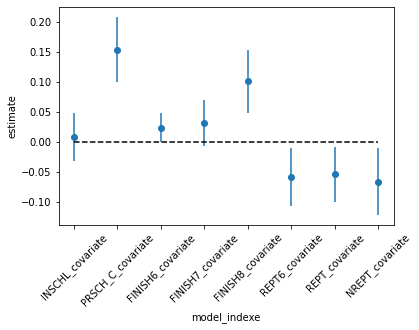

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

estimate = going_private_results['estimate']
estimate_error = going_private_results['estimate'] - going_private_results['0.025']  # 信頼区間と推定値の差をエラーバーの長さとする

xmin = 0
xmax = going_private_results.shape[0] - 1

plt.errorbar(range(xmax+1), estimate, estimate_error, fmt='o')
plt.hlines(y=0, xmin=xmin, xmax=xmax, colors='k', linestyles='dashed')
plt.xlabel('model_indexe')
plt.ylabel('estimate')
plt.xticks(range(going_private_results.shape[0]), going_private_results['model_index'], rotation=45)
plt.show()